# Análisis del dato

In [460]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
#from sklearn.metrics import r2_score
from sklearn import metrics
import statsmodels


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns

import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [461]:
data=pd.read_csv("/home/pablo/Descargas/TFG/SerieCompletaNatalidad.csv", parse_dates=["Periodo"], index_col="Periodo")

/tmp/ipykernel_5016/2677156176.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data=pd.read_csv("/home/pablo/Descargas/TFG/SerieCompletaNatalidad.csv", parse_dates=["Periodo"], index_col="Periodo")


In [462]:
data.sort_values(by='Periodo', ascending=True, inplace=True)

## Vista general de los datos

In [463]:
data

,Tasa Natalidad bruta
Periodo,
1975-12-01,18.7000
1976-01-01,18.7025
1976-02-01,18.7050
1976-03-01,18.7075
1976-04-01,18.7100
...,...
2023-08-01,6.7000
2023-09-01,6.6775
2023-10-01,6.6550


In [464]:
data.columns

Index(['Tasa Natalidad bruta'], dtype='object')

In [465]:
#Metodos de diferenciación
data['diff_1']=data['Tasa Natalidad bruta'].diff(1)
data['diff_2']=data['Tasa Natalidad bruta'].diff(2)
data['diff_log']=np.log(data['Tasa Natalidad bruta']).diff(1)

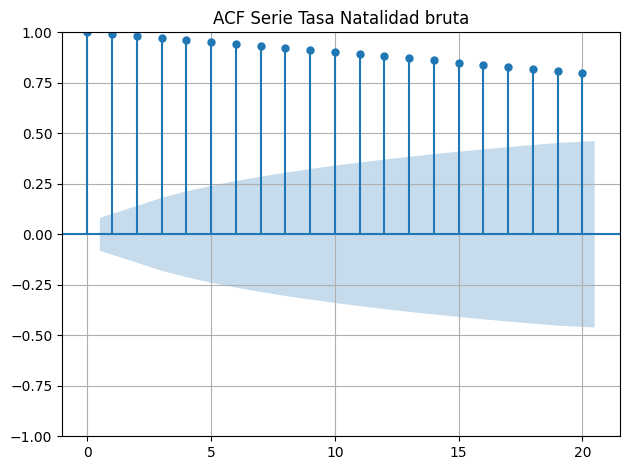

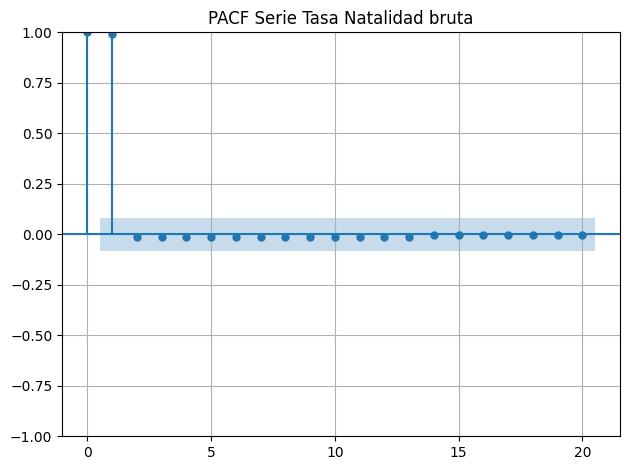

In [466]:
#autocorrelaciones sin diferencias
#plt.figure(figsize=(15,10))

plot_acf(data['Tasa Natalidad bruta'].dropna(), lags=20, ax=plt.gca(), title='ACF Serie Tasa Natalidad bruta')
plt.grid(True)
plt.tight_layout()
plt.show()

plot_pacf(data['Tasa Natalidad bruta'].dropna(), lags=20, ax=plt.gca(), title='PACF Serie Tasa Natalidad bruta')
plt.grid(True)
plt.tight_layout()
plt.show()

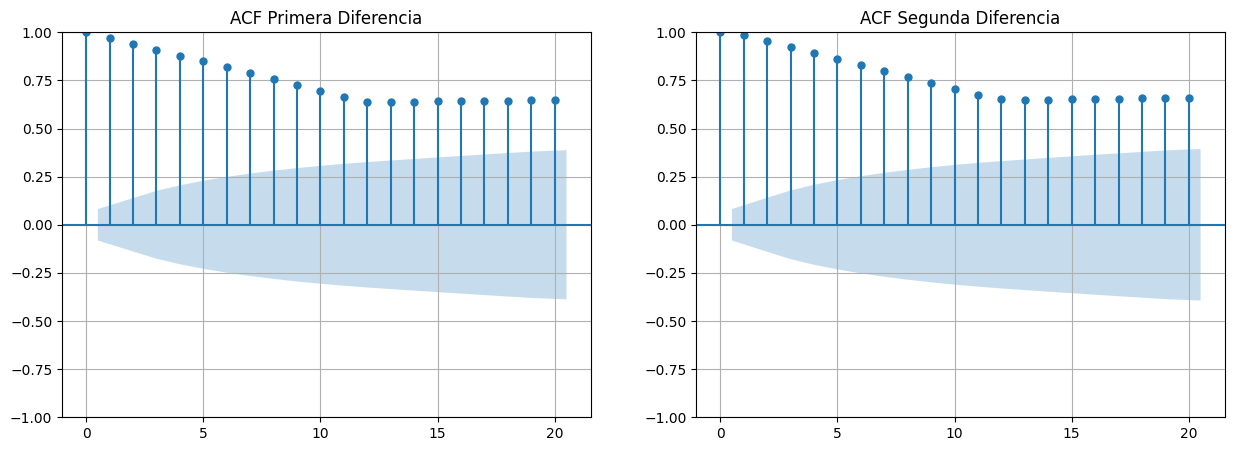

In [467]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plot_acf(data['diff_1'].dropna(), lags=20, ax=plt.gca(), title='ACF Primera Diferencia')
plt.grid(True)

plt.subplot(1,2,2)
plot_acf(data['diff_2'].dropna(), lags=20, ax=plt.gca(), title='ACF Segunda Diferencia')
plt.grid(True)
plt.show()

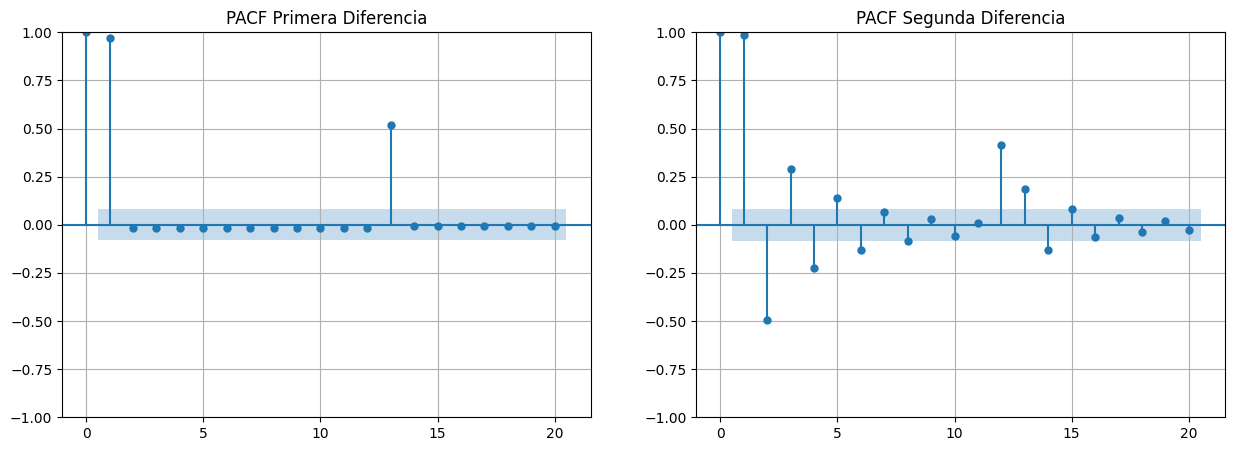

In [468]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plot_pacf(data['diff_1'].dropna(), lags=20, ax=plt.gca(), title='PACF Primera Diferencia')
plt.grid(True)

plt.subplot(1,2,2)
plot_pacf(data['diff_2'].dropna(), lags=20, ax=plt.gca(), title='PACF Segunda Diferencia')
plt.grid(True)
plt.show()

Nos indica que la mejor diferenciación es de 2

## División en train y test 

In [469]:
objetivo='Tasa Natalidad bruta'

#Divido en train (75%) y test (25%)
tamaño_train=int(len(data) * 0.75)
train, test=data[:tamaño_train], data[tamaño_train:]

In [470]:
train

,Tasa Natalidad bruta,diff_1,diff_2,diff_log
Periodo,,,,
1975-12-01,18.700000,NaN,NaN,NaN
1976-01-01,18.702500,0.002500,NaN,0.000134
1976-02-01,18.705000,0.002500,0.005000,0.000134
1976-03-01,18.707500,0.002500,0.005000,0.000134
1976-04-01,18.710000,0.002500,0.005000,0.000134
...,...,...,...,...
2011-07-01,10.215833,-0.029167,-0.058333,-0.002851
2011-08-01,10.186667,-0.029167,-0.058333,-0.002859
2011-09-01,10.157500,-0.029167,-0.058333,-0.002867


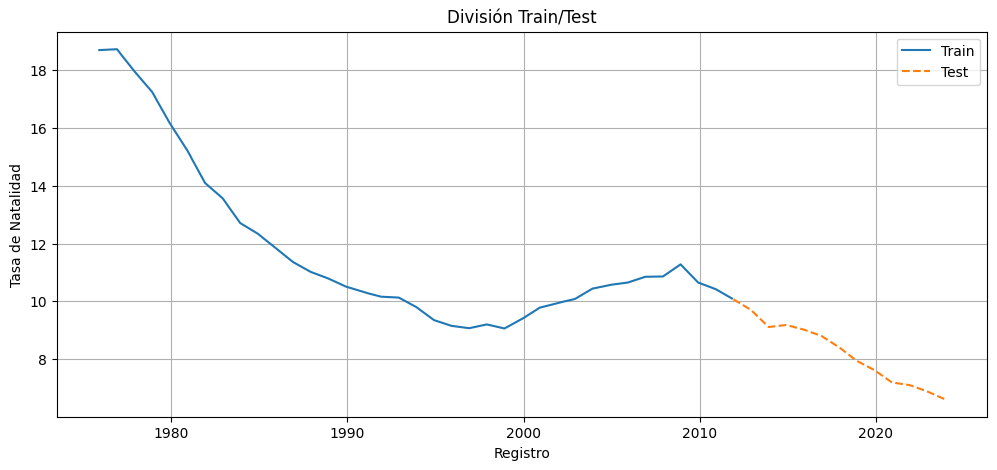

In [471]:
#Visualizo le serie
plt.figure(figsize=(12,5))
plt.plot(train[objetivo], label='Train')
plt.plot(test[objetivo], label='Test', linestyle='dashed')

plt.legend()
plt.xlabel("Registro")
plt.ylabel("Tasa de Natalidad")
plt.title('División Train/Test')
plt.grid(True)
plt.show()

## Arima

UTILIZAMOS LA FUNCION AUTOARIMA

In [472]:
#encuentro los mejores parámetros con ayuda de la funcion autoarima
def parametros_optimos_arima(data):
    modelo=auto_arima(data,
                      start_p=0, start_q=0, #empiezo sin términos autorregresivos ni de media movil
                      max_p=25, max_q=25, #valor habitual
                      m=1, #indico uno pues no hay estacionalidad en los datos
                      seasonal=False, #indico falso pues el modelo no tiene estacionalidad
                      d=None, #determino d como "2" ya que en número de diferencias necesarias para que sea estacionaria es 2
                      trace=True, #imprimo resultadps
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True) #utilizo enfoque paso a paso
    
    return modelo.order

In [473]:
orden=parametros_optimos_arima(data=train[objetivo])

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-2948.850, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-2946.849, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-2946.850, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-2950.811, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-2944.850, Time=0.09 sec

Best model:  ARIMA(0,2,0)(0,0,0)[0]          
Total fit time: 0.395 seconds


In [474]:
modelo_arima=ARIMA(train[objetivo], order=orden)
resultados_arima=modelo_arima.fit()
print("AKAIKE")
print(resultados_arima.aic)

#Predicción
pred_arima=resultados_arima.forecast(len(test))

AKAIKE
-2950.8113873786506


/home/pablo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/pablo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/pablo/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [475]:
resultados_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                SARIMAX Results                                 
================================================================================
Dep. Variable:     Tasa Natalidad bruta   No. Observations:                  432
Model:                   ARIMA(0, 2, 0)   Log Likelihood                1476.406
Date:                  Wed, 14 May 2025   AIC                          -2950.811
Time:                          21:30:34   BIC                          -2946.748
Sample:                      12-01-1975   HQIC                         -2949.207
                           - 11-01-2011                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      6.098e-05    7.7e-07     79.220      0.000    5.95e-05    6.25e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             57551.46
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -3.46
Prob(H) (two-sided):                  0.72   Kurtosis:                        59.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Residuos

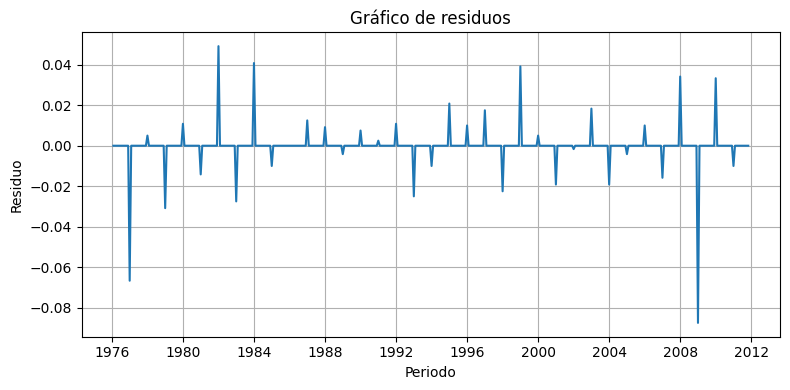

In [476]:
residuos=resultados_arima.resid
plt.figure(figsize=(8, 4))
plt.plot(residuos[2:], label="")
plt.title("Gráfico de residuos")
plt.ylabel("Residuo")
plt.xlabel("Periodo")
plt.tight_layout()
plt.grid(True)
plt.show()

<Figure size 800x400 with 0 Axes>

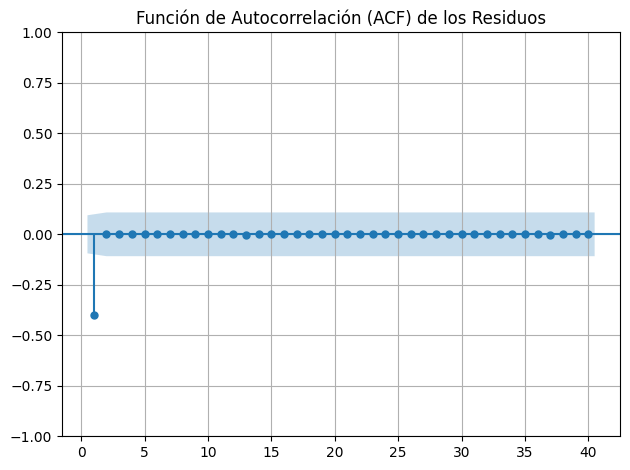

In [477]:
plt.figure(figsize=(8, 4))
plot_acf(residuos, lags=40, zero=False, title="Función de Autocorrelación (ACF) de los Residuos")
plt.tight_layout()
plt.grid(True)
plt.show()

In [478]:
residuos=residuos.dropna()
residuos=residuos.values.flatten()
print("nuevo shape:", residuos.shape)

nuevo shape: (432,)


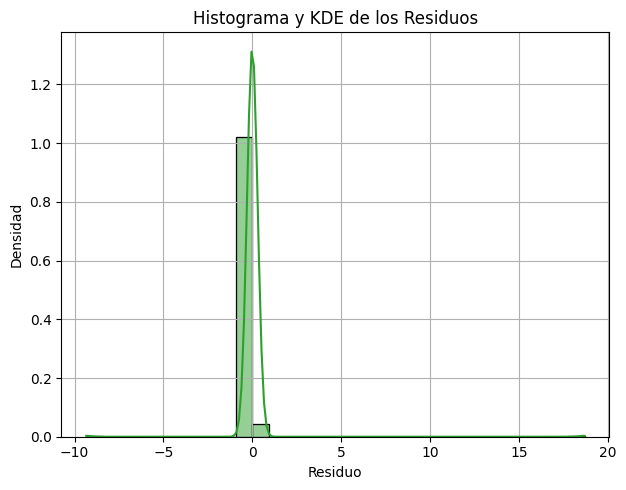

In [479]:
plt.figure(figsize=(12, 5))

#Q–Q
#plt.subplot(1, 2, 1)
#qqplot(residuos, line='45', ax=plt.gca())
#plt.title("Q–Q Plot de los Residuos")

#Histograma y KDE
plt.subplot(1, 2, 2)
sns.histplot(residuos,
             bins=30,
             kde=True,
             stat="density",
             color='C2')
plt.title("Histograma y KDE de los Residuos")
plt.xlabel("Residuo")
plt.ylabel("Densidad")
plt.tight_layout()
plt.grid(True)
plt.show()

### Métricas

In [481]:
#Metrica R²
r2_arima=metrics.r2_score(test[objetivo], pred_arima)
print(f"R² Modelo ARIMA: {r2_arima:.4f}")

#Metrica RMSE
rmse_arima=metrics.root_mean_squared_error(test[objetivo], pred_arima)
print(f"RMSE Modelo ARIMA: {rmse_arima:.4f}")

#Metrica MAPE
mape_arima=metrics.mean_absolute_percentage_error(test[objetivo], pred_arima)
print(f"MAPE Modelo ARIMA: {mape_arima:.4f}")

R² Modelo ARIMA: 0.8488
RMSE Modelo ARIMA: 0.3949
MAPE Modelo ARIMA: 0.0445


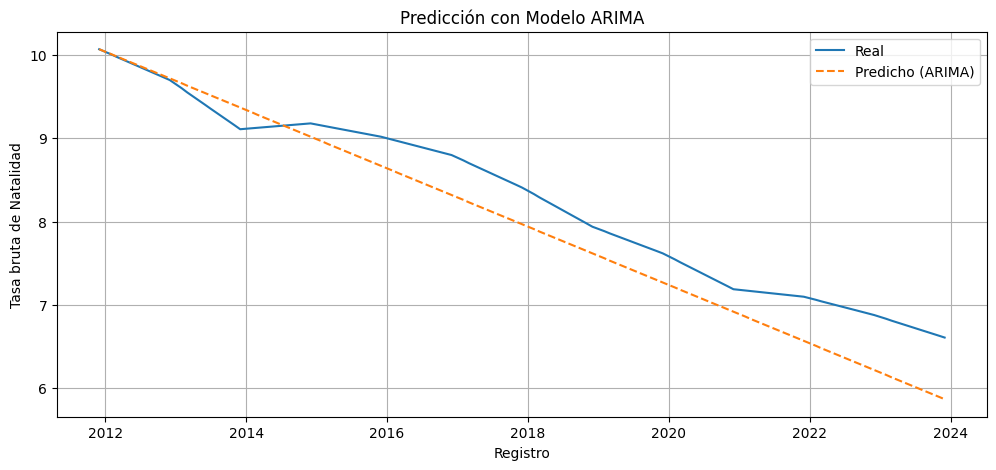

In [343]:
#Visualizacion
plt.figure(figsize=(12,5))
plt.plot(test[objetivo], label="Real")
plt.plot(pred_arima, label="Predicho (ARIMA)", linestyle='dashed')
plt.legend()
plt.title("Predicción con Modelo ARIMA")
plt.xlabel("Registro")
plt.ylabel("Tasa bruta de Natalidad")
plt.grid(True)
plt.show()

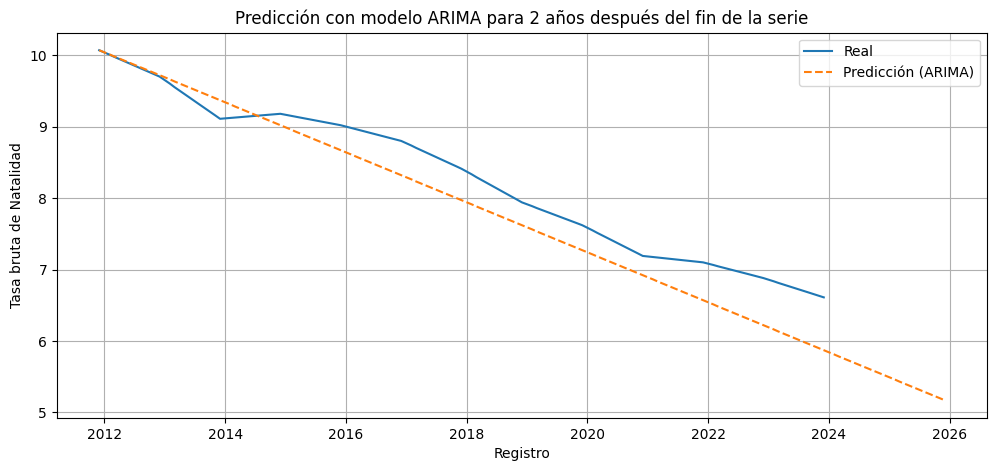

In [344]:
#Prediccion a futuro
pred_arima_futura=resultados_arima.forecast(len(test)+24)

#Visualizacion
plt.figure(figsize=(12,5))
plt.plot(test[objetivo], label="Real")
plt.plot(pred_arima_futura, label="Predicción (ARIMA)", linestyle='dashed')
plt.legend()
plt.title("Predicción con modelo ARIMA para 2 años después del fin de la serie")
plt.xlabel("Registro")
plt.ylabel("Tasa bruta de Natalidad")
plt.grid(True)
plt.show()

# LSTM Pruebas

In [445]:
data['diff_1']=data[objetivo].diff()
data_nonulos=data.dropna()

#escalo
scaler=StandardScaler()
data_scaled=scaler.fit_transform(data_nonulos['diff_1'].values.reshape(-1, 1))

seq_length=10
tamaño_train=int(len(data_scaled) * 0.8)
train, test=data_scaled[:tamaño_train], data_scaled[tamaño_train:]

#sequencias
def create_sequences(data, seq_length):
    X, y=[], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

X_train, y_train=create_sequences(train, seq_length)
X_test, y_test=create_sequences(test, seq_length)

#convierto a tensores
X_train=torch.tensor(X_train, dtype=torch.float32).view(-1, seq_length, 1)
y_train=torch.tensor(y_train, dtype=torch.float32)
X_test=torch.tensor(X_test, dtype=torch.float32).view(-1, seq_length, 1)
y_test=torch.tensor(y_test, dtype=torch.float32)


In [446]:
#declaro
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(LSTM, self).__init__()
        self.lstm=nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc=nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _=self.lstm(x)
        out=out[:, -1, :]
        out=self.fc(out)
        return out

model=LSTM()
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)

#entreno
num_epochs=100
for epoch in range(num_epochs):
    model.train()
    output=model(X_train).squeeze()
    loss=criterion(output, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

/home/pablo/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([450, 1])) that is different to the input size (torch.Size([450])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 10/100, Loss: 1.2247
Epoch 20/100, Loss: 1.2244
Epoch 30/100, Loss: 1.2242
Epoch 40/100, Loss: 1.2241
Epoch 50/100, Loss: 1.2241
Epoch 60/100, Loss: 1.2241
Epoch 70/100, Loss: 1.2241
Epoch 80/100, Loss: 1.2241
Epoch 90/100, Loss: 1.2241
Epoch 100/100, Loss: 1.2241


### Predicción

In [447]:
#realizo la predicción a 24 meses
horizonte_pred=24
última_secuencia=data_scaled[-seq_length:].reshape(1, seq_length, 1)
última_secuencia_tensor=torch.tensor(última_secuencia, dtype=torch.float32)

futuras_diffs=[]

for _ in range(horizonte_pred):
    with torch.no_grad():
        pred=model(última_secuencia_tensor)
        futuras_diffs.append(pred.item())

        # Concatenar predicción a la secuencia
        pred_reshape=pred.view(1, 1, 1)
        nueva_secuencia=torch.cat((última_secuencia_tensor[:, 1:, :], pred_reshape), dim=1)
        última_secuencia_tensor=nueva_secuencia

# Invertir el escalado y limitar valores
futuras_diffs_rescaled=scaler.inverse_transform(np.array(futuras_diffs).reshape(-1, 1))
futuras_diffs_rescaled=np.clip(futuras_diffs_rescaled, -5, 5)  # Evitar extremos

# Reintegrar para obtener la predicción en valores originales
último_valor_real=data[objetivo].iloc[-1]
pred_reconstruida=[]
valor_actual=último_valor_real

for diff in futuras_diffs_rescaled.flatten():
    valor_actual += diff
    pred_reconstruida.append(valor_actual)

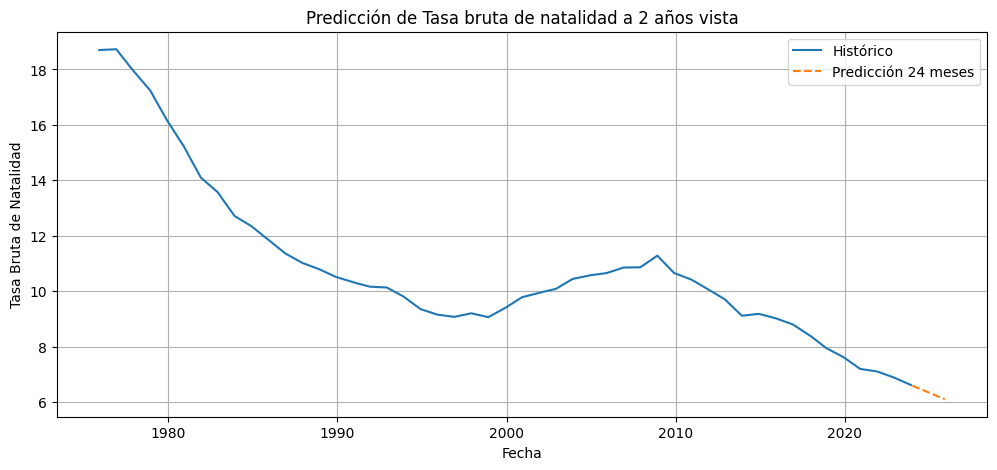

In [457]:
#visualizo
fechas_futuras=pd.date_range(start=data.index[-1] + pd.offsets.MonthBegin(1), periods=horizonte_pred, freq='MS')

plt.figure(figsize=(12, 5))
plt.plot(data.index, data[objetivo], label="Histórico")
plt.plot(fechas_futuras, pred_reconstruida, label="Predicción 24 meses", linestyle='--')
plt.title("Predicción de Tasa bruta de natalidad a 2 años vista")
plt.xlabel("Fecha")
plt.ylabel("Tasa Bruta de Natalidad")
plt.legend()
plt.grid(True)
#plt.tight_layout()
plt.show()

In [488]:
pred_reconstruida

[6.58862423704229,
 6.5672154208332705,
 6.545916574464015,
 6.5245323628497225,
 6.503101719555343,
 6.481767943969875,
 6.460414929803966,
 6.439204869232263,
 6.417867454241094,
 6.396473275063781,
 6.375159782651878,
 6.353787487216205,
 6.332415863208138,
 6.310997525252314,
 6.289680117362061,
 6.268440930618984,
 6.247183415287687,
 6.225866333593432,
 6.204618985417458,
 6.183320050065178,
 6.161954548314469,
 6.140611340753679,
 6.1193056214031945,
 6.097907697166918]

In [449]:
model

LSTM(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

### Residuos

In [450]:
model.eval()
with torch.no_grad():
    pred_test=model(X_test).numpy()
    y_test_np=y_test.numpy()
    
    #invierto escalado
    pred_test_rescaled=scaler.inverse_transform(pred_test)
    y_test_rescaled=scaler.inverse_transform(y_test_np.reshape(-1, 1))
    
    #obtengo valores originales a partir del ultimo vlor antes de test
    ultimo_valor_train=data[objetivo].iloc[tamaño_train + seq_length - 1]
    y_test_reconstruida=np.cumsum(y_test_rescaled) + ultimo_valor_train
    pred_test_reconstruida=np.cumsum(pred_test_rescaled) + ultimo_valor_train

    residuos=y_test_reconstruida.flatten() - pred_test_reconstruida.flatten()


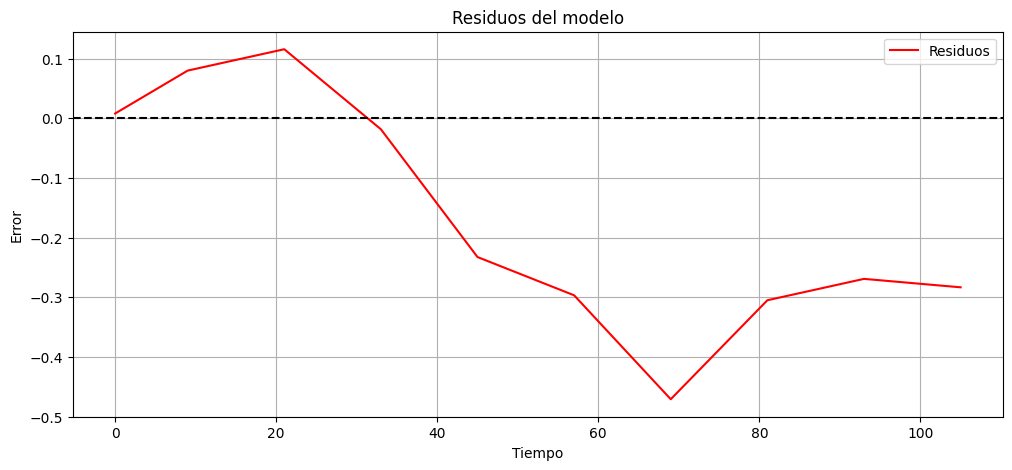

In [451]:
#residuos
plt.figure(figsize=(12, 5))
plt.plot(residuos, label="Residuos", color='red')
plt.axhline(0, color='black', linestyle='--')
plt.title("Residuos del modelo")
plt.xlabel("Tiempo")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
#plt.tight_layout()
plt.show()


<Figure size 1000x400 with 0 Axes>

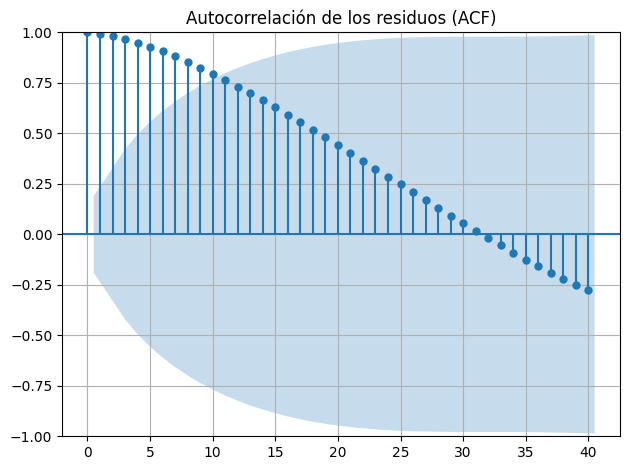

In [452]:
#ACF de los residuos
plt.figure(figsize=(10, 4))
plot_acf(residuos, lags=40)
plt.title("Autocorrelación de los residuos (ACF)")
plt.tight_layout()
plt.grid(True)
plt.show()


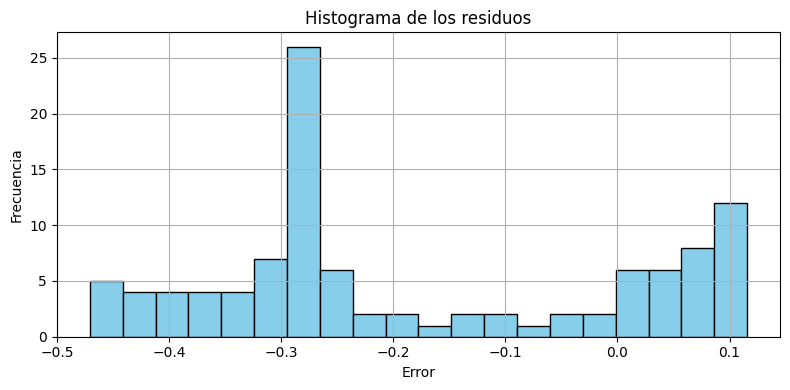

In [453]:
#histograma
plt.figure(figsize=(8, 4))
plt.hist(residuos, bins=20, color='skyblue', edgecolor='black')
plt.title("Histograma de los residuos")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()


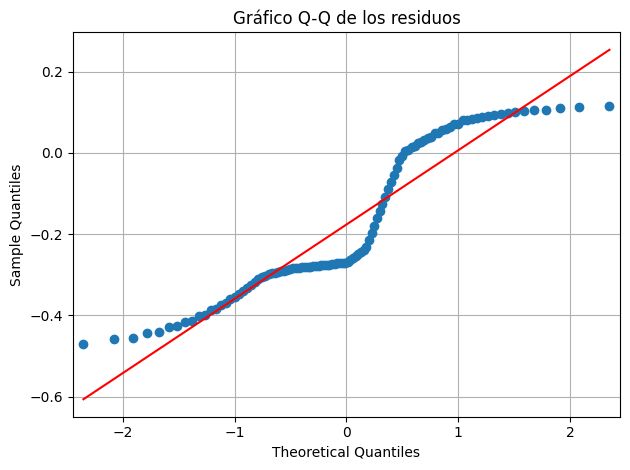

In [454]:
#grafico Q-Q
sm.qqplot(residuos, line='s')
plt.title("Gráfico Q-Q de los residuos")
plt.tight_layout()
plt.grid(True)
plt.show()


In [458]:
#metricas
rmse_lstm=metrics.mean_squared_error(y_test_reconstruida, pred_test_reconstruida)
mape_lstm=metrics.mean_absolute_percentage_error(y_test_reconstruida, pred_test_reconstruida)
r2_lstm=metrics.r2_score(y_test_reconstruida, pred_test_reconstruida)

print(f"RMSE: {rmse_lstm:.4f}")
print(f"MAPE: {mape_lstm:.2f}")
print(f"R²: {r2_lstm:.4f}")


RMSE: 0.0646
MAPE: 0.03
R²: 0.9016


## Comparativa

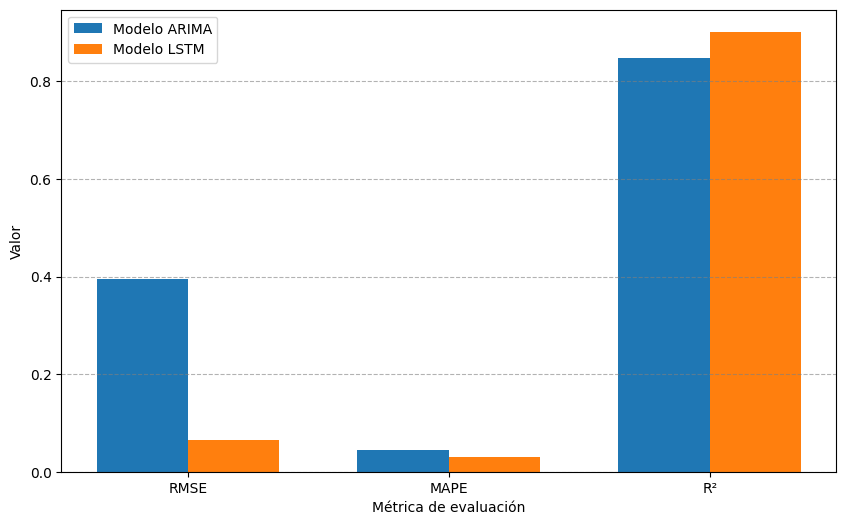

In [487]:
metricas = ['RMSE', 'MAPE', 'R²']
metricas_modelo_arima = [rmse_arima, mape_arima, r2_arima]
metricas_modelo_lstm = [rmse_lstm, mape_lstm, r2_lstm]

bar_width = 0.35
index = np.arange(len(metricas))

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(index - bar_width/2, metricas_modelo_arima, bar_width, label='Modelo ARIMA')
rects2 = ax.bar(index + bar_width/2, metricas_modelo_lstm, bar_width, label='Modelo LSTM')

ax.set_xlabel('Métrica de evaluación')
ax.set_ylabel('Valor')
#ax.set_title('Comparación de metricas (RMSE, MAPE, R²) entre modelos')
ax.grid(axis='y', linestyle='--', alpha=0.6, color='gray', zorder=0)
ax.set_xticks(index)
ax.set_xticklabels(metricas)
ax.legend()